# Far-field Beam Simulation and Window Function Simons Observatory Large Aperture Telescope
### Grace E. Chesmore and Jeff McMahon - McMahonCosmologyGroup

We will simulate the far-field beam of the SO LAT using ray-tracing technique. We will simulate the SO LAT geometry with a range of surface panel errors. We will then compute the window function of each far-field beam, demonstrating how surface panel errors impact the measurement constraints for SO's measurement of the cosmic microwave background (CMB). 

## Aperture Field Ray Trace
First we compute the far-field beams for mirror-surface RMS's of $20$, $30$, and $50$ $\mu m$. We define the geometry of the telescope, including scan resolution and receiver-feed position. 

In [1]:
import numpy as np
import tele_geo as tg
import optics_analyze as oa
import ap_field as af
import ap_fitting as afit
import pan_mod as pm
import far_field as ff

## Plot settings
import matplotlib
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")
CB_color_cycle = ["orange", "green", "#dd1c77", "#980043"]
import matplotlib.font_manager as font_manager

# font_manager.fontManager.addfont(
#     "/home/chesmore/.local/share/fonts/times-new-roman.ttf"
# )
# matplotlib.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams["font.size"] = 20
plt.rcParams["image.cmap"] = "magma"
plt.rcParams["axes.unicode_minus"] = False

# Define telescope geometry and adjuster positions on each mirror.
# We read in the tele_geo class defining the SO LAT geometry, and
# then specify parameters values:
tele_geo_t = tg.initialize_telescope_geometry()
tele_geo_t.N_scan = 200  # pixels in 1D of grid
tele_geo_t.de_ang = 0.25 / 60 * np.pi / 180  # angle increment of telescope scan [rad]
tele_geo_t.lambda_ = 0.002  # wavelength [m]
tele_geo_t.k = 2 * np.pi / tele_geo_t.lambda_  # wavenumber [1/m]
tele_geo_t.th_fwhp = 44 * np.pi / 180  # full width half power of source feed [rad]
# Receiver feed position in focal plane
rx_t = np.array([0, 0, 0])
tele_geo_t.rx_x = rx_t[0]
tele_geo_t.rx_y = rx_t[1]
tele_geo_t.rx_z = rx_t[2]
tele_geo_t.z_tow = 1e7  # Distance from tower to aperture plane [m]
tele_geo_t.el0 = np.arctan(
    -tele_geo_t.y_tow / tele_geo_t.z_tow
)  # elevation of telescope based on position of source tower [rad]
if tele_geo_t.lambda_ == 0.002:
    tele_geo_t.x_ap = -7.2

adj_1_A = np.random.randn(1092) * 35
adj_2_A = np.random.randn(1092) * 35
adj_1_B = np.random.randn(1092) * 23
adj_2_B = np.random.randn(1092) * 23
adj_1_C = np.random.randn(1092) * 15
adj_2_C = np.random.randn(1092) * 15
adj_1_E = np.random.randn(1092) * 0
adj_2_E = np.random.randn(1092) * 0

We now use a ray tracing method to determine the aperture fields. First we use the adjuster offsets to predict create a "panel model" (i.e. where a given ray in the ray trace hits the primary and secondary mirrors). The panel model is used to build the amplitude and path-length of the rays at the aperture.

In [ ]:
# Define panels on M1 and M2. Here you can define the
# magnitude of the adjuster offsets on each mirror:

save = 0  # Option to save adjuster offsets to .txt file

pan_mod2_tA = pm.panel_model_from_adjuster_offsets(
    2, adj_2_A, 1, save
)  # Panel Model on M2
pan_mod1_tA = pm.panel_model_from_adjuster_offsets(
    1, adj_1_A, 1, save
)  # Panel Model on M1

pan_mod2_tB = pm.panel_model_from_adjuster_offsets(
    2, adj_2_B, 1, save
)  # Panel Model on M2
pan_mod1_tB = pm.panel_model_from_adjuster_offsets(
    1, adj_1_B, 1, save
)  # Panel Model on M1

pan_mod2_tC = pm.panel_model_from_adjuster_offsets(
    2, adj_2_C, 1, save
)  # Panel Model on M2
pan_mod1_tC = pm.panel_model_from_adjuster_offsets(
    1, adj_1_C, 1, save
)  # Panel Model on M1

pan_mod2_tE = pm.panel_model_from_adjuster_offsets(
    2, adj_2_E, 1, save
)  # Panel Model on M2
pan_mod1_tE = pm.panel_model_from_adjuster_offsets(
    1, adj_1_E, 1, save
)  # Panel Model on M1

# Repeat with no panel errors:
pan_mod2b = pm.panel_model_from_adjuster_offsets(
    2, 0, 0, save
)  # Panel Model on M2: 0  mm
pan_mod1b = pm.panel_model_from_adjuster_offsets(
    1, 0, 0, save
)  # Panel Model on M2: 35 mm

# FOV of RX (directions of outgoing rays from the receiver feed)
th = np.linspace(-np.pi / 2 - 0.28, -np.pi / 2 + 0.28, tele_geo_t.N_scan)
ph = np.linspace(np.pi / 2 - 0.28, np.pi / 2 + 0.28, tele_geo_t.N_scan)

# Path of the rays from the RX to the aperture plane
rxmirror_t = af.ray_mirror_pts(rx_t, tele_geo_t, th, ph)
out_tA = af.aperature_fields_from_panel_model(
    pan_mod1_tA, pan_mod2_tA, rx_t, tele_geo_t, th, ph, rxmirror_t
)
out_tB = af.aperature_fields_from_panel_model(
    pan_mod1_tB, pan_mod2_tB, rx_t, tele_geo_t, th, ph, rxmirror_t
)
out_tC = af.aperature_fields_from_panel_model(
    pan_mod1_tC, pan_mod2_tC, rx_t, tele_geo_t, th, ph, rxmirror_t
)
out_tE = af.aperature_fields_from_panel_model(
    pan_mod1_tE, pan_mod2_tE, rx_t, tele_geo_t, th, ph, rxmirror_t
)
out_tA_new = []
for ii in range(len(out_tA)):
    out_tA_new.append(out_tA[ii, :][np.where(out_tA[15, :] > 0)])
out_tB_new = []
for ii in range(len(out_tB)):
    out_tB_new.append(out_tB[ii, :][np.where(out_tB[15, :] > 0)])
out_tC_new = []
for ii in range(len(out_tC)):
    out_tC_new.append(out_tC[ii, :][np.where(out_tC[15, :] > 0)])
out_tE_new = []
for ii in range(len(out_tE)):
    out_tE_new.append(out_tE[ii, :][np.where(out_tE[15, :] > 0)])

In [4]:
out_tA_new = np.array(out_tA_new)
out_tB_new = np.array(out_tB_new)
out_tC_new = np.array(out_tC_new)
out_tE_new = np.array(out_tE_new)

# Apodize beam amplitude and phase to a 5.5 m diameter
rad = np.sqrt(
    out_tE_new[3, :] ** 2 + (out_tE_new[4, :] - np.mean(out_tE_new[4, :])) ** 2
)
out_tA_new[15, :] = np.where(
    rad < 2.75e3, out_tA_new[15, :] - np.mean(out_tA_new[15, :]), 0
)
out_tA_new[16, :] = np.where(rad < 2.75e3, out_tA_new[16, :], 0)
out_tB_new[15, :] = np.where(
    rad < 2.75e3, out_tB_new[15, :] - np.mean(out_tB_new[15, :]), 0
)
out_tB_new[16, :] = np.where(rad < 2.75e3, out_tB_new[16, :], 0)
out_tC_new[15, :] = np.where(
    rad < 2.75e3, out_tC_new[15, :] - np.mean(out_tC_new[15, :]), 0
)
out_tC_new[16, :] = np.where(rad < 2.75e3, out_tC_new[16, :], 0)
out_tE_new[15, :] = np.where(
    rad < 2.75e3, out_tE_new[15, :] - np.mean(out_tE_new[15, :]), 0
)
out_tE_new[16, :] = np.where(rad < 2.75e3, out_tE_new[16, :], 0)

## Far Field Beams
Here we simulate far-field measurements using each of the panel models we have just created. We then save these simulations as .txt files and read them in to analyze as we would with a real measurement taken by the telescope. 

In [5]:
beam_tA = ff.far_field_sim(out_tA_new, tele_geo_t, rx_t)
beam_tB = ff.far_field_sim(out_tB_new, tele_geo_t, rx_t)
beam_tC = ff.far_field_sim(out_tC_new, tele_geo_t, rx_t)
beam_tE = ff.far_field_sim(out_tE_new, tele_geo_t, rx_t)

In [6]:
beam_A = np.reshape(beam_tA[2, :], (2 * tele_geo_t.N_scan, 2 * tele_geo_t.N_scan))
beam_B = np.reshape(beam_tB[2, :], (2 * tele_geo_t.N_scan, 2 * tele_geo_t.N_scan))
beam_C = np.reshape(beam_tC[2, :], (2 * tele_geo_t.N_scan, 2 * tele_geo_t.N_scan))
beam_E = np.reshape(beam_tE[2, :], (2 * tele_geo_t.N_scan, 2 * tele_geo_t.N_scan))

xx = np.reshape(beam_tE[0, :], (2 * tele_geo_t.N_scan, 2 * tele_geo_t.N_scan))
yy = np.reshape(beam_tE[1, :], (2 * tele_geo_t.N_scan, 2 * tele_geo_t.N_scan))
beam_A /= np.max(abs(beam_A))  # normalizing the beam
beam_B /= np.max(abs(beam_B))
beam_C /= np.max(abs(beam_C))
beam_E /= np.max(abs(beam_E))

path = "/data/chesmore/sim_out/"  # path where you save far-field simulations.
np.savetxt(
    path + "sim_A.txt",
    np.c_[
        np.real(beam_tA[0, :]),
        np.real(beam_tA[1, :]),
        np.real(beam_tA[2, :]),
        np.imag(beam_tA[2, :]),
    ],
)
np.savetxt(
    path + "sim_B.txt",
    np.c_[
        np.real(beam_tB[0, :]),
        np.real(beam_tB[1, :]),
        np.real(beam_tB[2, :]),
        np.imag(beam_tB[2, :]),
    ],
)
np.savetxt(
    path + "sim_C.txt",
    np.c_[
        np.real(beam_tC[0, :]),
        np.real(beam_tC[1, :]),
        np.real(beam_tC[2, :]),
        np.imag(beam_tC[2, :]),
    ],
)
np.savetxt(
    path + "sim_E.txt",
    np.c_[
        np.real(beam_tE[0, :]),
        np.real(beam_tE[1, :]),
        np.real(beam_tE[2, :]),
        np.imag(beam_tE[2, :]),
    ],
)

## Ruze Equation: 
To check the simulated signal distortion from surface errors to the theoretical prediction, we use Ruze's equation, which relates the gain of an antenna to an antenna's surface errors. The Ruze equation for a parabolic mirror is: 
$$G(\epsilon) = G_0 e^{ - \big(\frac{4\pi\epsilon}{\lambda} \big)^2 } $$
where $\epsilon$ is the RMS of the surface errors, $\lambda$ is the wavelength of our signal, $G_0$ is the gain of the far field beam with $0\,\mu m$ error RMS. 

In [7]:
reference_motion_correction = 1  # Option to include reference motion correction
# when analyzing of the far-field beam.
shift = ["x", oa.sh_x(rx_t[0])]  # Calculating the shift to center the aperture field
# based on the receiver feed location
# in the focal plane.
panels_of_rays = af.panel_pts(pan_mod1b, pan_mod2b, rx_t, tele_geo_t)
rxmirror = af.ray_mirror_pts(rx_t, tele_geo_t, th, ph)

dat_A = np.loadtxt(path + "sim_A.txt")
dat_B = np.loadtxt(path + "sim_B.txt")
dat_C = np.loadtxt(path + "sim_C.txt")

x, y, phase_A, ampl_A, geo = afit.analyze_holography(
    dat_A, tele_geo_t, 0, reference_motion_correction, 0, shift
)
x, y, phase_B, ampl_B, geo = afit.analyze_holography(
    dat_B, tele_geo_t, 0, reference_motion_correction, 0, shift
)
x, y, phase_C, ampl_C, geo = afit.analyze_holography(
    dat_C, tele_geo_t, 0, reference_motion_correction, 0, shift
)
surf_err_C = (
    1e6
    * (
        phase_C[np.where((x ** 2 + y ** 2 <= 5.5))]
        - np.mean(phase_C[np.where((x ** 2 + y ** 2 <= 5.5))])
    )
    / tele_geo_t.k
)
surf_err_C = np.sqrt(np.sum(surf_err_C ** 2) / len(surf_err_C))
surf_err_B = (
    1e6
    * (
        phase_B[np.where((x ** 2 + y ** 2 <= 5.5))]
        - np.mean(phase_B[np.where((x ** 2 + y ** 2 <= 5.5))])
    )
    / tele_geo_t.k
)
surf_err_B = np.sqrt(np.sum(surf_err_B ** 2) / len(surf_err_B))
surf_err_A = (
    1e6
    * (
        phase_A[np.where((x ** 2 + y ** 2 <= 5.5))]
        - np.mean(phase_A[np.where((x ** 2 + y ** 2 <= 5.5))])
    )
    / tele_geo_t.k
)
surf_err_A = np.sqrt(np.sum(surf_err_A ** 2) / len(surf_err_A))

## Window Function
To learn about the constraints on the CMB measurements due to panel-surface RMS, we will compute the power spectrum of each of the far-field beams. To compute the power spectrum, we (1) apply a 2D FFT, (2) take the absolute value squared of this map in Fourier space ($k_x$ and $k_y$), and (3) average the signal in annular bins of $k = \sqrt{k_x^2 + k_y^2}$. These bins are converted to bins in $\ell$ with the scaling: $\ell = k* 2 \pi$.

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


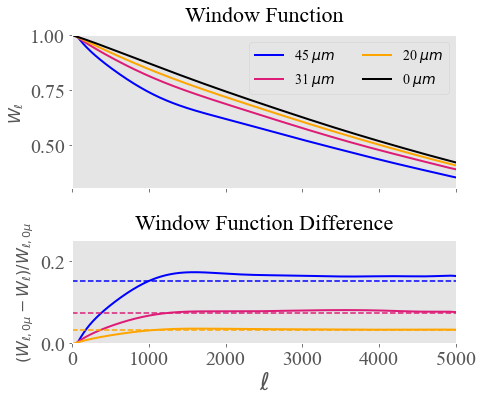

In [8]:
# Constants for plotting
delta_ell = 50.0
ell_max = 5e3
N = len(beam_A)
pix_size = tele_geo_t.de_ang * 60 * 180 / np.pi  # size of a pixel [arcminutes]

# Compute the far-field beams' power spectra:
binned_ell, binned_spectrum_A = oa.calculate_2d_spectrum(
    beam_A, beam_A, delta_ell, ell_max, pix_size, N
)
binned_ell, binned_spectrum_B = oa.calculate_2d_spectrum(
    beam_B, beam_B, delta_ell, ell_max, pix_size, N
)
binned_ell, binned_spectrum_C = oa.calculate_2d_spectrum(
    beam_C, beam_C, delta_ell, ell_max, pix_size, N
)
binned_ell, binned_spectrum_E = oa.calculate_2d_spectrum(
    beam_E, beam_E, delta_ell, ell_max, pix_size, N
)

xp = np.linspace(0, 5000, 1000)
pA = np.polyfit(
    binned_ell[np.where(np.isnan(binned_spectrum_A) == False)],
    binned_spectrum_A[np.where(np.isnan(binned_spectrum_A) == False)],
    10,
)
pB = np.polyfit(
    binned_ell[np.where(np.isnan(binned_spectrum_B) == False)],
    binned_spectrum_B[np.where(np.isnan(binned_spectrum_B) == False)],
    10,
)
pC = np.polyfit(
    binned_ell[np.where(np.isnan(binned_spectrum_C) == False)],
    binned_spectrum_C[np.where(np.isnan(binned_spectrum_C) == False)],
    10,
)
pE = np.polyfit(
    binned_ell[np.where(np.isnan(binned_spectrum_E) == False)],
    binned_spectrum_E[np.where(np.isnan(binned_spectrum_E) == False)],
    10,
)

window_A = np.poly1d(pA)
window_B = np.poly1d(pB)
window_C = np.poly1d(pC)
window_E = np.poly1d(pE)

# Plot the results:
CB_color_cycle = ["orange", "#dd1c77", "#980043", "b"]
f, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(7, 6), gridspec_kw={"height_ratios": [1.5, 1]}, sharex=True
)
ax1.set_title("Window Function", fontsize=22, y=1.05)
ax1.plot(
    xp,
    window_A(xp),
    color=CB_color_cycle[3],
    linewidth=2,
    label=r"%d $\mu m$" % surf_err_A,
)
ax1.plot(
    xp,
    window_B(xp),
    color=CB_color_cycle[1],
    linewidth=2,
    label=r"%d $\mu m$" % surf_err_B,
)
ax1.plot(
    xp,
    window_C(xp),
    color=CB_color_cycle[0],
    linewidth=2,
    label=r"%d $\mu m$" % surf_err_C,
)
ax1.plot(
    xp,
    window_E(xp),
    color="k",
    linewidth=2,
    label=r"0 $\mu m$",
)
ax1.legend(ncol=2, fontsize=14)
ax1.set_ylabel(r"$W_\ell$", fontsize=16)
ax1.set_ylim(0.3, 1)

ax2.set_title("Window Function Difference", fontsize=22, y=1.05)
ax2.plot(
    xp,
    (window_E(xp) - window_A(xp)) / window_E(xp),
    linewidth=2,
    color=CB_color_cycle[3],
    label=r"%d $\mu m$" % surf_err_A,
)
ax2.plot(
    xp,
    (window_E(xp) - window_B(xp)) / window_E(xp),
    linewidth=2,
    color=CB_color_cycle[1],
    label=r"%d $\mu m$" % surf_err_B,
)
ax2.plot(
    xp,
    (window_E(xp) - window_C(xp)) / window_E(xp),
    linewidth=2,
    color=CB_color_cycle[0],
    label=r"%d $\mu m$" % surf_err_C,
)

ax1.grid()
ax2.grid()
ax2.axhline(
    y=1 - oa.ruze(surf_err_A * 1e-6, tele_geo_t.lambda_),
    color=CB_color_cycle[3],
    linestyle="--",
)
ax2.axhline(
    y=1 - oa.ruze(surf_err_B * 1e-6, tele_geo_t.lambda_),
    color=CB_color_cycle[1],
    linestyle="--",
)
ax2.axhline(
    y=1 - oa.ruze(surf_err_C * 1e-6, tele_geo_t.lambda_),
    color=CB_color_cycle[0],
    linestyle="--",
)
# ax2.legend(ncol=2, fontsize=14)
ax2.set_ylabel(r"$(W_{\ell,0\mu}-W_{\ell})/W_{\ell,0\mu}$", fontsize=16)
ax2.set_xlabel(r"$\ell$")
ax2.set_ylim(0, 0.25)
ax2.set_xlim(0, 5e3)
ax2.set_xlim(0, 5e3)
plt.tight_layout(w_pad=1)
# plt.savefig('../../../../Figs/win_func.pdf',bbox_inches = 'tight')
plt.show()

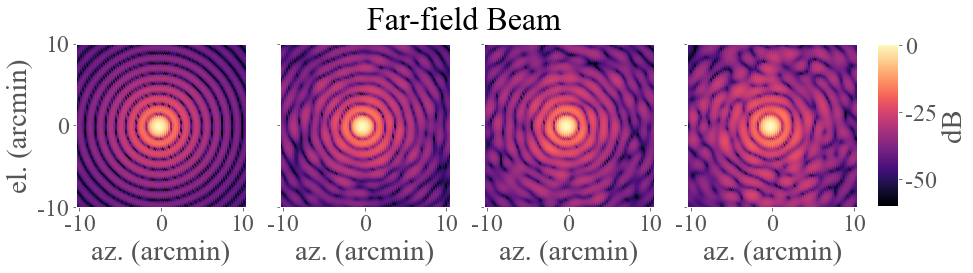

In [15]:
matplotlib.rcParams["font.size"] = 24
f, axes = plt.subplots(1, 4, figsize=(14, 3), sharey=True)
plt.suptitle("Far-field Beam", fontsize=32, x=0.51, y=1.05)
first = axes[0].scatter(
    beam_tE[0, :] * 180 / np.pi * 60,
    beam_tE[1, :] * 180 / np.pi * 60,
    c=20 * np.log10(abs(beam_tE[2, :]) / np.max(beam_tE[2, :])),
    vmin=-60,
)
# axes[1].scatter(beam_tD[0,:]*180/np.pi * 60,beam_tD[1,:]*180/np.pi * 60,c=20*np.log10(abs(beam_tD[2,:])/np.max(beam_tD[2,:])),vmin = -60)
axes[1].scatter(
    beam_tC[0, :] * 180 / np.pi * 60,
    beam_tC[1, :] * 180 / np.pi * 60,
    c=20 * np.log10(abs(beam_tC[2, :]) / np.max(beam_tC[2, :])),
    vmin=-60,
)
axes[2].scatter(
    beam_tB[0, :] * 180 / np.pi * 60,
    beam_tB[1, :] * 180 / np.pi * 60,
    c=20 * np.log10(abs(beam_tB[2, :]) / np.max(beam_tB[2, :])),
    vmin=-60,
)
axes[3].scatter(
    beam_tA[0, :] * 180 / np.pi * 60,
    beam_tA[1, :] * 180 / np.pi * 60,
    c=20 * np.log10(abs(beam_tA[2, :]) / np.max(beam_tA[2, :])),
    vmin=-60,
)
axes[0].axis("equal")
axes[1].axis("equal")
axes[2].axis("equal")
axes[3].axis("equal")
axes[3].axis("equal")
axes[0].set_xlim(-10, 10)
axes[0].set_ylim(-10, 10)
axes[1].set_xlim(-10, 10)
axes[1].set_ylim(-10, 10)
axes[2].set_xlim(-10, 10)
axes[2].set_ylim(-10, 10)
axes[3].set_xlim(-10, 10)
axes[3].set_ylim(-10, 10)
axes[0].set_ylabel("el. (arcmin)")
axes[0].set_xlabel("az. (arcmin)")
axes[1].set_xlabel("az. (arcmin)")
axes[2].set_xlabel("az. (arcmin)")
axes[3].set_xlabel("az. (arcmin)")
cbar_posit = [0.92, 0.13, 0.02, 0.75]
cbaxes = f.add_axes(cbar_posit)
cbar = plt.colorbar(first, cax=cbaxes, label="dB")
plt.savefig('far_fields.png',bbox_inches = 'tight')
plt.show()